![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)

# <h1><center>Tutorial  <a href="https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/mjx/tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

This notebook provides an introductory tutorial for [**MuJoCo XLA (MJX)**](https://github.com/google-deepmind/mujoco/blob/main/mjx), a JAX-based implementation of MuJoCo useful for RL training workloads.

**A Colab runtime with GPU acceleration is required.** If you're using a CPU-only runtime, you can switch using the menu "Runtime > Change runtime type".










### Copyright notice

> <p><small><small>Copyright 2023 DeepMind Technologies Limited.</small></p>
> <p><small><small>Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0">http://www.apache.org/licenses/LICENSE-2.0</a>.</small></small></p>
> <p><small><small>Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.</small></small></p>

# Install MuJoCo, MJX, and Brax

In [1]:
# !pip install mujoco
# !pip install mujoco_mjx
# !pip install brax

In [2]:
# #@title Check if MuJoCo installation was successful

# from google.colab import files

# import distutils.util
# import os
# import subprocess
# if subprocess.run('nvidia-smi').returncode:
#   raise RuntimeError(
#       'Cannot communicate with GPU. '
#       'Make sure you are using a GPU Colab runtime. '
#       'Go to the Runtime menu and select Choose runtime type.')

# # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# # This is usually installed as part of an Nvidia driver package, but the Colab
# # kernel doesn't install its driver via APT, and as a result the ICD is missing.
# # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#   with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#     f.write("""{
#     "file_format_version" : "1.0.0",
#     "ICD" : {
#         "library_path" : "libEGL_nvidia.so.0"
#     }
# }
# """)

# # Configure MuJoCo to use the EGL rendering backend (requires GPU)
# print('Setting environment variable to use GPU rendering:')
# %env MUJOCO_GL=egl

# try:
#   print('Checking that the installation succeeded:')
#   import mujoco
#   mujoco.MjModel.from_xml_string('<mujoco/>')
# except Exception as e:
#   raise e from RuntimeError(
#       'Something went wrong during installation. Check the shell output above '
#       'for more information.\n'
#       'If using a hosted Colab runtime, make sure you enable GPU acceleration '
#       'by going to the Runtime menu and selecting "Choose runtime type".')

# print('Installation successful.')

In [3]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List
from tqdm import tqdm

# Graphics and plotting.
# print('Installing mediapy:')
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [4]:
#@title Import MuJoCo, MJX, and Brax

from datetime import datetime
import functools
import jax
from jax import numpy as jp
import numpy as np
from typing import Any, Dict, Tuple, Union

from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, State
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import model
from etils import epath
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx


# Training a Policy with MJX
MJX is an implementation of MuJoCo written in [JAX](https://jax.readthedocs.io/en/latest/index.html), enabling large batch training on GPU/TPU. In this notebook, we demonstrate how to train RL policies with MJX.

First, we implement an environment `State` so that we can plug into the [Brax](https://github.com/google/brax) environment API. `State` holds the observation, reward, metrics, and environment info. Notably `State.pipeline_state` holds a `mjx.Data` object, which is analogous to `mjData` in MuJoCo.


In [5]:
#@title State

@struct.dataclass
class State(Base):
  """Environment state for training and inference with brax.

  Args:
    pipeline_state: the physics state, mjx.Data
    obs: environment observations
    reward: environment reward
    done: boolean, True if the current episode has terminated
    metrics: metrics that get tracked per environment step
    info: environment variables defined and updated by the environment reset
      and step functions
  """

  pipeline_state: mjx.Data
  obs: jax.Array
  reward: jax.Array
  done: jax.Array
  metrics: Dict[str, jax.Array] = struct.field(default_factory=dict)
  info: Dict[str, Any] = struct.field(default_factory=dict)



Next, we implement `MjxEnv`, an environment class we'll use through the notebook. `MjxEnv` initializes a `mjx.Model` and `mjx.Data` object. Notice that `MjxEnv` calls `mjx.step` for every `pipeline_step`, which is analgous to `mujoco.mj_step`.

`MjxEnv` also inherits from `brax.envs.base.Env` which allows us to use the training agents implemented in brax.

In [6]:
#@title MjxEnv

class MjxEnv(Env):
  """API for driving an MJX system for training and inference in brax."""

  def __init__(
      self,
      mj_model: mujoco.MjModel,
      physics_steps_per_control_step: int = 1,
  ):
    """Initializes MjxEnv.

    Args:
      mj_model: mujoco.MjModel
      physics_steps_per_control_step: the number of times to step the physics
        pipeline for each environment step
    """
    self.model = mj_model
    self.data = mujoco.MjData(mj_model)
    self.sys = mjx.device_put(mj_model)
    self._physics_steps_per_control_step = physics_steps_per_control_step

  def pipeline_init(
      self, qpos: jax.Array, qvel: jax.Array
  ) -> mjx.Data:
    """Initializes the physics state."""
    data = mjx.device_put(self.data)
    data = data.replace(qpos=qpos, qvel=qvel, ctrl=jp.zeros(self.sys.nu))
    data = mjx.forward(self.sys, data)
    return data

  def pipeline_step(
      self, data: mjx.Data, ctrl: jax.Array
  ) -> mjx.Data:
    """Takes a physics step using the physics pipeline."""
    def f(data, _):
      data = data.replace(ctrl=ctrl)
      return (
          mjx.step(self.sys, data),
          None,
      )
    data, _ = jax.lax.scan(f, data, (), self._physics_steps_per_control_step)
    return data

  @property
  def dt(self) -> jax.Array:
    """The timestep used for each env step."""
    return self.sys.opt.timestep * self._physics_steps_per_control_step

  @property
  def observation_size(self) -> int:
    rng = jax.random.PRNGKey(0)
    reset_state = self.unwrapped.reset(rng)
    return reset_state.obs.shape[-1]

  @property
  def action_size(self) -> int:
    return self.sys.nu

  @property
  def backend(self) -> str:
    return 'mjx'

  def _pos_vel(
      self, data: mjx.Data
      ) -> Tuple[Transform, Motion]:
    """Returns 6d spatial transform and 6d velocity for all bodies."""
    x = Transform(pos=data.xpos[1:, :], rot=data.xquat[1:, :])
    cvel = Motion(vel=data.cvel[1:, 3:], ang=data.cvel[1:, :3])
    offset = data.xpos[1:, :] - data.subtree_com[
        self.model.body_rootid[np.arange(1, self.model.nbody)]]
    xd = Transform.create(pos=offset).vmap().do(cvel)
    return x, xd


Finally we can implement a real environment. We choose to first implement the Humanoid environment. Notice that `reset` initializes a `State`, and `step` steps through the physics step and reward logic. The reward and stepping logic train the Humanoid to run forwards.

In [7]:
#@title Humanoid Env

class Humanoid(MjxEnv):

  def __init__(
      self,
      forward_reward_weight=1.25,
      ctrl_cost_weight=0.1,
      healthy_reward=5.0,
      terminate_when_unhealthy=True,
      healthy_z_range=(1.0, 2.0),
      reset_noise_scale=1e-2,
      exclude_current_positions_from_observation=True,
      **kwargs,
  ):
    path = epath.Path(epath.resource_path('mujoco')) / (
        'mjx/benchmark/model/humanoid'
    )
    mj_model = mujoco.MjModel.from_xml_path(
        (path / 'humanoid.xml').as_posix())
    mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
    mj_model.opt.iterations = 6
    mj_model.opt.ls_iterations = 6

    physics_steps_per_control_step = 5
    kwargs['physics_steps_per_control_step'] = kwargs.get(
        'physics_steps_per_control_step', physics_steps_per_control_step)

    super().__init__(mj_model=mj_model, **kwargs)

    self._forward_reward_weight = forward_reward_weight
    self._ctrl_cost_weight = ctrl_cost_weight
    self._healthy_reward = healthy_reward
    self._terminate_when_unhealthy = terminate_when_unhealthy
    self._healthy_z_range = healthy_z_range
    self._reset_noise_scale = reset_noise_scale
    self._exclude_current_positions_from_observation = (
        exclude_current_positions_from_observation
    )

  def reset(self, rng: jp.ndarray) -> State:
    """Resets the environment to an initial state."""
    rng, rng1, rng2 = jax.random.split(rng, 3)

    low, hi = -self._reset_noise_scale, self._reset_noise_scale
    qpos = self.sys.qpos0 + jax.random.uniform(
        rng1, (self.sys.nq,), minval=low, maxval=hi
    )
    qvel = jax.random.uniform(
        rng2, (self.sys.nv,), minval=low, maxval=hi
    )

    data = self.pipeline_init(qpos, qvel)

    obs = self._get_obs(data, jp.zeros(self.sys.nu))
    reward, done, zero = jp.zeros(3)
    metrics = {
        'forward_reward': zero,
        'reward_linvel': zero,
        'reward_quadctrl': zero,
        'reward_alive': zero,
        'x_position': zero,
        'y_position': zero,
        'distance_from_origin': zero,
        'x_velocity': zero,
        'y_velocity': zero,
    }
    return State(data, obs, reward, done, metrics)

  def step(self, state: State, action: jp.ndarray) -> State:
    """Runs one timestep of the environment's dynamics."""
    data0 = state.pipeline_state
    data = self.pipeline_step(data0, action)

    com_before = data0.subtree_com[1]
    com_after = data.subtree_com[1]
    velocity = (com_after - com_before) / self.dt
    forward_reward = self._forward_reward_weight * velocity[0]

    min_z, max_z = self._healthy_z_range
    is_healthy = jp.where(data.qpos[2] < min_z, x=0.0, y=1.0)
    is_healthy = jp.where(
        data.qpos[2] > max_z, x=0.0, y=is_healthy
    )
    if self._terminate_when_unhealthy:
      healthy_reward = self._healthy_reward
    else:
      healthy_reward = self._healthy_reward * is_healthy

    ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))

    obs = self._get_obs(data, action)
    reward = forward_reward + healthy_reward - ctrl_cost
    done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
    state.metrics.update(
        forward_reward=forward_reward,
        reward_linvel=forward_reward,
        reward_quadctrl=-ctrl_cost,
        reward_alive=healthy_reward,
        x_position=com_after[0],
        y_position=com_after[1],
        distance_from_origin=jp.linalg.norm(com_after),
        x_velocity=velocity[0],
        y_velocity=velocity[1],
    )

    return state.replace(
        pipeline_state=data, obs=obs, reward=reward, done=done
    )

  def _get_obs(
      self, data: mjx.Data, action: jp.ndarray
  ) -> jp.ndarray:
    """Observes humanoid body position, velocities, and angles."""
    position = data.qpos
    if self._exclude_current_positions_from_observation:
      position = position[2:]

    # external_contact_forces are excluded
    return jp.concatenate([
        position,
        data.qvel,
        data.cinert[1:].ravel(),
        data.cvel[1:].ravel(),
        data.qfrc_actuator,
    ])


envs.register_environment('humanoid', Humanoid)

In [9]:
import yaml
from typing import List, Dict, Text

def load_params(param_path: Text) -> Dict:
    with open(param_path, "rb") as file:
        params = yaml.safe_load(file)
    return params

params = load_params("params/params.yaml")
model = mujoco.MjModel.from_xml_path(params["XML_PATH"])

In [10]:
#@title Humanoid Env

class Rodent(MjxEnv):

  def __init__(
      self,
      forward_reward_weight=1.25,
      ctrl_cost_weight=0.1,
      healthy_reward=5.0,
      terminate_when_unhealthy=True,
      healthy_z_range=(1.0, 2.0),
      reset_noise_scale=1e-2,
      exclude_current_positions_from_observation=True,
      **kwargs,
  ):
    params = load_params("params/params.yaml")
    mj_model = mujoco.MjModel.from_xml_path(params["XML_PATH"])
    mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
    mj_model.opt.iterations = 6
    mj_model.opt.ls_iterations = 6

    physics_steps_per_control_step = 5
    kwargs['physics_steps_per_control_step'] = kwargs.get(
        'physics_steps_per_control_step', physics_steps_per_control_step)

    super().__init__(mj_model=mj_model, **kwargs)

    self._forward_reward_weight = forward_reward_weight
    self._ctrl_cost_weight = ctrl_cost_weight
    self._healthy_reward = healthy_reward
    self._terminate_when_unhealthy = terminate_when_unhealthy
    self._healthy_z_range = healthy_z_range
    self._reset_noise_scale = reset_noise_scale
    self._exclude_current_positions_from_observation = (
        exclude_current_positions_from_observation
    )

  def reset(self, rng: jp.ndarray) -> State:
    """Resets the environment to an initial state."""
    rng, rng1, rng2 = jax.random.split(rng, 3)

    low, hi = -self._reset_noise_scale, self._reset_noise_scale
    qpos = self.sys.qpos0 + jax.random.uniform(
        rng1, (self.sys.nq,), minval=low, maxval=hi
    )
    qvel = jax.random.uniform(
        rng2, (self.sys.nv,), minval=low, maxval=hi
    )

    data = self.pipeline_init(qpos, qvel)

    obs = self._get_obs(data, jp.zeros(self.sys.nu))
    reward, done, zero = jp.zeros(3)
    metrics = {
        'forward_reward': zero,
        'reward_linvel': zero,
        'reward_quadctrl': zero,
        'reward_alive': zero,
        'x_position': zero,
        'y_position': zero,
        'distance_from_origin': zero,
        'x_velocity': zero,
        'y_velocity': zero,
    }
    return State(data, obs, reward, done, metrics)

  def step(self, state: State, action: jp.ndarray) -> State:
    """Runs one timestep of the environment's dynamics."""
    data0 = state.pipeline_state
    data = self.pipeline_step(data0, action)

    com_before = data0.subtree_com[1]
    com_after = data.subtree_com[1]
    velocity = (com_after - com_before) / self.dt
    forward_reward = self._forward_reward_weight * velocity[0]

    min_z, max_z = self._healthy_z_range
    is_healthy = jp.where(data.qpos[2] < min_z, x=0.0, y=1.0)
    is_healthy = jp.where(
        data.qpos[2] > max_z, x=0.0, y=is_healthy
    )
    if self._terminate_when_unhealthy:
      healthy_reward = self._healthy_reward
    else:
      healthy_reward = self._healthy_reward * is_healthy

    ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))

    obs = self._get_obs(data, action)
    reward = forward_reward + healthy_reward - ctrl_cost
    done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
    state.metrics.update(
        forward_reward=forward_reward,
        reward_linvel=forward_reward,
        reward_quadctrl=-ctrl_cost,
        reward_alive=healthy_reward,
        x_position=com_after[0],
        y_position=com_after[1],
        distance_from_origin=jp.linalg.norm(com_after),
        x_velocity=velocity[0],
        y_velocity=velocity[1],
    )

    return state.replace(
        pipeline_state=data, obs=obs, reward=reward, done=done
    )

  def _get_obs(
      self, data: mjx.Data, action: jp.ndarray
  ) -> jp.ndarray:
    """Observes humanoid body position, velocities, and angles."""
    position = data.qpos
    if self._exclude_current_positions_from_observation:
      position = position[2:]

    # external_contact_forces are excluded
    return jp.concatenate([
        position,
        data.qvel,
        data.cinert[1:].ravel(),
        data.cvel[1:].ravel(),
        data.qfrc_actuator,
    ])


envs.register_environment('rodent', Rodent)

## Visualize a Rollout

Let's instantiate the environment and visualize a short rollout.

NOTE: Since episodes terminates early if the torso is below the healthy z-range, the only relevant contacts for this task are between the feet and the plane. We turn off other contacts.

In [11]:
# instantiate the environment
env_name = 'rodent'
env = envs.get_environment(env_name)

# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

# instantiate the renderer
renderer = mujoco.Renderer(env.model)

In [12]:
#@title Define a render utility function

def get_image(state: State, camera: str) -> np.ndarray:
  """Renders the environment state."""
  d = mujoco.MjData(env.model)
  # write the mjx.Data into an mjData object
  mjx.device_get_into(d, state.pipeline_state)
  mujoco.mj_forward(env.model, d)
  # use the mjData object to update the renderer
  renderer.update_scene(d, camera=camera)
  return renderer.render()


In [14]:
# initialize the state
state = jit_reset(jax.random.PRNGKey(5))
rollout = [state]
images = [get_image(state, camera='side')]

# grab a trajectory
for i in tqdm(range(500)):
  ctrl = -0.1 * jp.ones(env.sys.nu)
  state = jit_step(state, ctrl)
  rollout.append(state)
  images.append(get_image(state, camera='side'))

media.show_video(images, fps=1.0 / env.dt)

100%|█████████████████████████████████████████| 500/500 [05:32<00:00,  1.50it/s]


## Train Humanoid Policy

Let's finally train a policy with PPO to make the Humanoid run forwards. Training takes about 13-14 minutes on a Tesla V100 GPU.

/Users/scottyang/anaconda3/envs/stac-jax/lib/python3.12/site-packages/matplotlib/axes/_axes.py:3672: RuntimeWarning: divide by zero encountered in negative
  if np.any(np.less(err, -err, out=res, where=(err == err))):
/Users/scottyang/anaconda3/envs/stac-jax/lib/python3.12/site-packages/matplotlib/axes/_axes.py:3672: RuntimeWarning: divide by zero encountered in equal
  if np.any(np.less(err, -err, out=res, where=(err == err))):
/Users/scottyang/anaconda3/envs/stac-jax/lib/python3.12/site-packages/matplotlib/axes/_axes.py:3672: RuntimeWarning: divide by zero encountered in less
  if np.any(np.less(err, -err, out=res, where=(err == err))):
/Users/scottyang/anaconda3/envs/stac-jax/lib/python3.12/site-packages/matplotlib/axes/_axes.py:3680: RuntimeWarning: divide by zero encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err


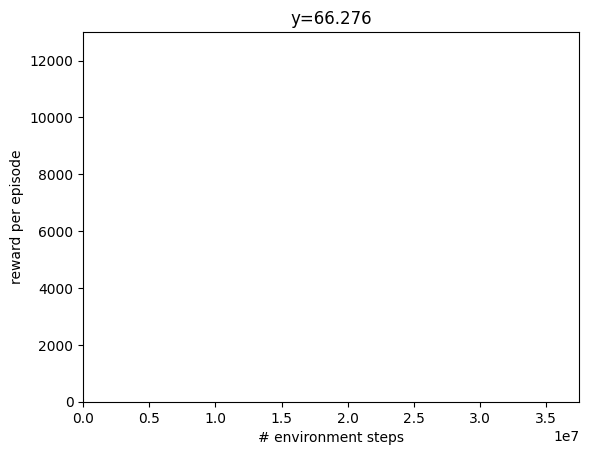

In [ ]:
train_fn = functools.partial(
    ppo.train, num_timesteps=30_000_000, num_evals=5, reward_scaling=0.1,
    episode_length=1000, normalize_observations=True, action_repeat=1,
    unroll_length=10, num_minibatches=32, num_updates_per_batch=8,
    discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048,
    batch_size=1024, seed=0)


x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = 13000, 0
def progress(num_steps, metrics):
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

  plt.xlim([0, train_fn.keywords['num_timesteps'] * 1.25])
  plt.ylim([min_y, max_y])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'y={y_data[-1]:.3f}')

  plt.errorbar(
      x_data, y_data, yerr=ydataerr)
  plt.show()

make_inference_fn, params, _= train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

## Save and Load Policy

We can save and load the policy using the brax model API.

In [ ]:
#@title Save Model
model_path = '/tmp/mjx_brax_policy'
model.save_params(model_path, params)

In [ ]:
#@title Load Model and Define Inference Function
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

## Visualize Policy

Finally we can visualize the policy.

In [ ]:
eval_env = envs.get_environment(env_name)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

In [ ]:
# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state]
images = [get_image(state, camera='side')]

# grab a trajectory
n_steps = 500
render_every = 2

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state)
  if i % render_every == 0:
    images.append(get_image(state, camera='side'))

  if state.done:
    break

media.show_video(images, fps=1.0 / eval_env.dt / render_every)

# MJX Policy in MuJoCo

Note that we can also perform the physics step using the original MuJoCo python bindings to show that the policy trained in MJX works in MuJoCo.

In [ ]:
mj_model = eval_env.model
mj_data = mujoco.MjData(mj_model)

renderer = mujoco.Renderer(mj_model)
ctrl = jp.zeros(mj_model.nu)

images = []
for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)

  obs = eval_env._get_obs(mjx.device_put(mj_data), ctrl)
  ctrl, _ = jit_inference_fn(obs, act_rng)

  mj_data.ctrl = ctrl
  for _ in range(eval_env._physics_steps_per_control_step):
    mujoco.mj_step(mj_model, mj_data)  # Physics step using MuJoCo mj_step.

  if i % render_every == 0:
    renderer.update_scene(mj_data, camera='side')
    images.append(renderer.render())

media.show_video(images, fps=1.0 / eval_env.dt / render_every)

# Domain Randomization

We might also want to include randomization over certain `mjModel` parameters while training a policy. In MJX, we can easily create a batch of environments with randomized values populated in `mjx.Model`. Below, we show a function that randomizes friction and actuator gain/bias.

In [ ]:
def domain_randomize(sys, rng):
  """Randomizes the mjx.Model."""
  @jax.vmap
  def rand(rng):
    _, key = jax.random.split(rng, 2)
    # friction
    friction = jax.random.uniform(key, (1,), minval=0.6, maxval=1.4)
    friction = sys.geom_friction.at[:, 0].set(friction)
    # actuator
    _, key = jax.random.split(key, 2)
    gain_range = (-10, -5)
    param = jax.random.uniform(
        key, (1,), minval=gain_range[0], maxval=gain_range[1]
    ) + sys.actuator_gainprm[:, 0]
    gain = sys.actuator_gainprm.at[:, 0].set(param)
    bias = sys.actuator_biasprm.at[:, 1].set(-param)
    return friction, gain, bias

  friction, gain, bias = rand(rng)

  in_axes = jax.tree_map(lambda x: None, sys)
  in_axes = in_axes.tree_replace({
      'geom_friction': 0,
      'actuator_gainprm': 0,
      'actuator_biasprm': 0,
  })

  sys = sys.tree_replace({
      'geom_friction': friction,
      'actuator_gainprm': gain,
      'actuator_biasprm': bias,
  })

  return sys, in_axes

If we wanted 10 environments with randomized friction and actuator params, we can call `domain_randomize`, which returns a batched `mjModel` along with a dictionary specifying the axes that are batched.

In [ ]:
rng = jax.random.PRNGKey(0)
rng = jax.random.split(rng, 10)
batched_sys, _ = domain_randomize(env.sys, rng)

print('Single env friction shape: ', env.sys.geom_friction.shape)
print('Batched env friction shape: ', batched_sys.geom_friction.shape)

print('Friction on geom 0: ', env.sys.geom_friction[0, 0])
print('Random frictions on geom 0: ', batched_sys.geom_friction[:, 0, 0])

## Quadruped Env

Let's define a quadruped environment that takes advantage of the domain randomization function. Here we use the [Barkour v0 Quadruped](https://github.com/google-deepmind/mujoco_menagerie/tree/main/google_barkour_v0) and an environment that trains a joystick policy.

In [ ]:
#@title Barkour v0 Quadruped Env

def get_config():
  """Returns reward config for barkour quadruped environment."""

  def get_default_rewards_config():
    default_config = config_dict.ConfigDict(
        dict(
            # The coefficients for all reward terms used for training. All
            # physical quantities are in SI units, if no otherwise specified,
            # i.e. joint positions are in rad, positions are measured in meters,
            # torques in Nm, and time in seconds, and forces in Newtons.
            scales=config_dict.ConfigDict(
                dict(
                    # Tracking rewards are computed using exp(-delta^2/sigma)
                    # sigma can be a hyperparameters to tune.
                    # Track the base x-y velocity (no z-velocity tracking.)
                    tracking_lin_vel=1.5,
                    # Track the angular velocity along z-axis, i.e. yaw rate.
                    tracking_ang_vel=0.8,
                    # Below are regularization terms, we roughly divide the
                    # terms to base state regularizations, joint
                    # regularizations, and other behavior regularizations.
                    # Penalize the base velocity in z direction, L2 penalty.
                    lin_vel_z=-2.0,
                    # Penalize the base roll and pitch rate. L2 penalty.
                    ang_vel_xy=-0.05,
                    # Penalize non-zero roll and pitch angles. L2 penalty.
                    orientation=-5.0,
                    # L2 regularization of joint torques, |tau|^2.
                    # torques=-0.0002,
                    torques=-0.002,
                    # Penalize the change in the action and encourage smooth
                    # actions. L2 regularization |action - last_action|^2
                    action_rate=-0.1,
                    # Encourage long swing steps.  However, it does not
                    # encourage high clearances.
                    feet_air_time=0.2,
                    # Encourage no motion at zero command, L2 regularization
                    # |q - q_default|^2.
                    stand_still=-0.5,
                    # Early termination penalty.
                    termination=-1.0,
                    # Penalizing foot slipping on the ground.
                    foot_slip=-0.1,
                )
            ),
            # Tracking reward = exp(-error^2/sigma).
            tracking_sigma=0.25,
        )
    )
    return default_config

  default_config = config_dict.ConfigDict(
      dict(rewards=get_default_rewards_config(),))

  return default_config


class BarkourEnv(MjxEnv):
  """Environment for training the barkour quadruped joystick policy in MJX."""

  def __init__(
      self,
      obs_noise: float = 0.05,
      action_scale: float=0.3,
      **kwargs,
  ):
    path = epath.Path(epath.resource_path('mujoco')) / (
        'mjx/benchmark/model/barkour_v0/assets'
    )
    mj_model = mujoco.MjModel.from_xml_path(
        (path / 'barkour_v0_mjx.xml').as_posix())
    mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
    mj_model.opt.iterations = 4
    mj_model.opt.ls_iterations = 6

    physics_steps_per_control_step = 10
    kwargs['physics_steps_per_control_step'] = kwargs.get(
        'physics_steps_per_control_step', physics_steps_per_control_step)
    super().__init__(mj_model=mj_model, **kwargs)

    self.torso_idx = 1
    self._action_scale = action_scale
    self._obs_noise = obs_noise
    self._reset_horizon = 500
    self._feet_index = jp.array([3, 6, 9, 12])
    # local positions for each foot
    self._feet_pos = jp.array([
        [-0.191284, -0.0191638, 0.013],
        [-0.191284, -0.0191638, -0.013],
        [-0.191284, -0.0191638, 0.013],
        [-0.191284, -0.0191638, -0.013],
    ])
    self._init_q = mj_model.keyframe('standing').qpos
    self._default_ap_pose = mj_model.keyframe('standing').qpos[7:]
    self.reward_config = get_config()
    self.lowers = self._default_ap_pose - jp.array([0.2, 0.8, 0.8] * 4)
    self.uppers = self._default_ap_pose + jp.array([0.2, 0.8, 0.8] * 4)

  def sample_command(self, rng: jax.Array) -> jax.Array:
    lin_vel_x = [-0.6, 1.0]  # min max [m/s]
    lin_vel_y = [-0.8, 0.8]  # min max [m/s]
    ang_vel_yaw = [-0.7, 0.7]  # min max [rad/s]

    _, key1, key2, key3 = jax.random.split(rng, 4)
    lin_vel_x = jax.random.uniform(
        key1, (1,), minval=lin_vel_x[0], maxval=lin_vel_x[1]
    )
    lin_vel_y = jax.random.uniform(
        key2, (1,), minval=lin_vel_y[0], maxval=lin_vel_y[1]
    )
    ang_vel_yaw = jax.random.uniform(
        key3, (1,), minval=ang_vel_yaw[0], maxval=ang_vel_yaw[1]
    )
    new_cmd = jp.array([lin_vel_x[0], lin_vel_y[0], ang_vel_yaw[0]])
    return new_cmd

  def reset(self, rng: jax.Array) -> State:
    rng, key = jax.random.split(rng)

    qpos = jp.array(self._init_q)
    qvel = jp.zeros(self.model.nv)
    new_cmd = self.sample_command(key)
    data = self.pipeline_init(qpos, qvel)

    state_info = {
        'rng': rng,
        'last_act': jp.zeros(12),
        'last_vel': jp.zeros(12),
        'last_contact_buffer': jp.zeros((20, 4), dtype=bool),
        'command': new_cmd,
        'last_contact': jp.zeros(4, dtype=bool),
        'feet_air_time': jp.zeros(4),
        'obs_history': jp.zeros(15 * 31),
        'reward_tuple': {
            'tracking_lin_vel': 0.0,
            'tracking_ang_vel': 0.0,
            'lin_vel_z': 0.0,
            'ang_vel_xy': 0.0,
            'orientation': 0.0,
            'torque': 0.0,
            'action_rate': 0.0,
            'stand_still': 0.0,
            'feet_air_time': 0.0,
            'foot_slip': 0.0,
        },
        'step': 0,
    }

    x, xd = self._pos_vel(data)
    obs = self._get_obs(data.qpos, x, xd, state_info)
    reward, done = jp.zeros(2)
    metrics = {'total_dist': 0.0}
    for k in state_info['reward_tuple']:
      metrics[k] = state_info['reward_tuple'][k]
    state = State(data, obs, reward, done, metrics, state_info)
    return state

  def step(self, state: State, action: jax.Array) -> State:
    rng, rng_noise, cmd_rng = jax.random.split(
        state.info['rng'], 3
    )

    # physics step
    cur_action = jp.array(action)
    action = action[:12] * self._action_scale
    motor_targets = jp.clip(
        action + self._default_ap_pose, self.lowers, self.uppers
    )
    data = self.pipeline_step(state.pipeline_state, motor_targets)

    # observation data
    x, xd = self._pos_vel(data)
    obs = self._get_obs(data.qpos, x, xd, state.info)
    obs_noise = self._obs_noise * jax.random.uniform(
        rng_noise, obs.shape, minval=-1, maxval=1)
    qpos, qvel = data.qpos, data.qvel
    joint_angles = qpos[7:]
    joint_vel = qvel[6:]

    # foot contact data based on z-position
    foot_contact = 0.017 - self._get_feet_pos_vel(x, xd)[0][:, 2]
    contact = foot_contact > -1e-3  # a mm or less off the floor
    contact_filt_mm = jp.logical_or(contact, state.info['last_contact'])
    contact_filt_cm = jp.logical_or(
        foot_contact > -1e-2, state.info['last_contact']
    )
    first_contact = (state.info['feet_air_time'] > 0) * (contact_filt_mm)
    state.info['feet_air_time'] += self.dt

    # reward
    reward_tuple = {
        'tracking_lin_vel': (
            self._reward_tracking_lin_vel(state.info['command'], x, xd)
            * self.reward_config.rewards.scales.tracking_lin_vel
        ),
        'tracking_ang_vel': (
            self._reward_tracking_ang_vel(state.info['command'], x, xd)
            * self.reward_config.rewards.scales.tracking_ang_vel
        ),
        'lin_vel_z': (
            self._reward_lin_vel_z(xd)
            * self.reward_config.rewards.scales.lin_vel_z
        ),
        'ang_vel_xy': (
            self._reward_ang_vel_xy(xd)
            * self.reward_config.rewards.scales.ang_vel_xy
        ),
        'orientation': (
            self._reward_orientation(x)
            * self.reward_config.rewards.scales.orientation
        ),
        'torque': (
            self._reward_torques(data.qfrc_actuator)
            * self.reward_config.rewards.scales.torques
        ),
        'action_rate': (
            self._reward_action_rate(cur_action, state.info['last_act'])
            * self.reward_config.rewards.scales.action_rate
        ),
        'stand_still': (
            self._reward_stand_still(
                state.info['command'], joint_angles, self._default_ap_pose
            )
            * self.reward_config.rewards.scales.stand_still
        ),
        'feet_air_time': (
            self._reward_feet_air_time(
                state.info['feet_air_time'],
                first_contact,
                state.info['command'],
            )
            * self.reward_config.rewards.scales.feet_air_time
        ),
        'foot_slip': (
            self._reward_foot_slip(x, xd, contact_filt_cm)
            * self.reward_config.rewards.scales.foot_slip
        ),
    }
    reward = sum(reward_tuple.values())
    reward = jp.clip(reward * self.dt, 0.0, 10000.0)

    # state management
    state.info['last_act'] = cur_action
    state.info['last_vel'] = joint_vel
    state.info['feet_air_time'] *= ~contact_filt_mm
    state.info['last_contact'] = contact
    state.info['last_contact_buffer'] = jp.roll(
        state.info['last_contact_buffer'], 1, axis=0
    )
    state.info['last_contact_buffer'] = (
        state.info['last_contact_buffer'].at[0].set(contact)
    )
    state.info['reward_tuple'] = reward_tuple
    state.info['step'] += 1
    state.info.update(rng=rng)

    # resetting logic if joint limits are reached or robot is falling
    done = 0.0
    up = jp.array([0.0, 0.0, 1.0])
    done = jp.where(jp.dot(math.rotate(up, x.rot[0]), up) < 0, 1.0, done)
    done = jp.where(jp.logical_or(
        jp.any(joint_angles < .98 * self.lowers),
        jp.any(joint_angles > .98 * self.uppers)), 1.0, done)
    done = jp.where(x.pos[self.torso_idx, 2] < 0.18, 1.0, done)

    # termination reward
    reward += jp.where(
        (done == 1.0) & (state.info['step'] < self._reset_horizon),
        self.reward_config.rewards.scales.termination,
        0.0,
    )

    # when done, sample new command if more than _reset_horizon timesteps
    # achieved
    state.info['command'] = jp.where(
        (done == 1.0) & (state.info['step'] > self._reset_horizon),
        self.sample_command(cmd_rng), state.info['command'])
    # reset the step counter when done
    state.info['step'] = jp.where(
        (done == 1.0) | (state.info['step'] > self._reset_horizon), 0,
        state.info['step']
    )

    # log total displacement as a proxy metric
    state.metrics['total_dist'] = math.normalize(x.pos[self.torso_idx])[1]
    for k in state.info['reward_tuple'].keys():
      state.metrics[k] = state.info['reward_tuple'][k]

    state = state.replace(
        pipeline_state=data, obs=obs + obs_noise, reward=reward,
        done=done)
    return state

  def _get_obs(self, qpos: jax.Array, x: Transform, xd: Motion,
               state_info: Dict[str, Any]) -> jax.Array:
    # Get observations:
    # yaw_rate,  projected_gravity, command,  motor_angles, last_action

    inv_base_orientation = math.quat_inv(x.rot[0])
    local_rpyrate = math.rotate(xd.ang[0], inv_base_orientation)
    cmd = state_info['command']

    obs_list = []
    # yaw rate
    obs_list.append(jp.array([local_rpyrate[2]]) * 0.25)
    # projected gravity
    obs_list.append(
        math.rotate(jp.array([0.0, 0.0, -1.0]), inv_base_orientation))
    # command
    obs_list.append(cmd * jp.array([2.0, 2.0, 0.25]))
    # motor angles
    angles = qpos[7:19]
    obs_list.append(angles - self._default_ap_pose)
    # last action
    obs_list.append(state_info['last_act'])

    obs = jp.clip(jp.concatenate(obs_list), -100.0, 100.0)

    # stack observations through time
    single_obs_size = len(obs)
    state_info['obs_history'] = jp.roll(
        state_info['obs_history'], single_obs_size
    )
    state_info['obs_history'] = jp.array(
        state_info['obs_history']).at[:single_obs_size].set(obs)
    return state_info['obs_history']

  # ------------ reward functions----------------
  def _reward_lin_vel_z(self, xd: Motion) -> jax.Array:
    # Penalize z axis base linear velocity
    return jp.square(xd.vel[0, 2])

  def _reward_ang_vel_xy(self, xd: Motion) -> jax.Array:
    # Penalize xy axes base angular velocity
    return jp.sum(jp.square(xd.ang[0, :2]))

  def _reward_orientation(self, x: Transform) -> jax.Array:
    # Penalize non flat base orientation
    up = jp.array([0.0, 0.0, 1.0])
    rot_up = math.rotate(up, x.rot[0])
    return jp.sum(jp.square(rot_up[:2]))

  def _reward_torques(self, torques: jax.Array) -> jax.Array:
    # Penalize torques
    return jp.sqrt(jp.sum(jp.square(torques))) + jp.sum(jp.abs(torques))

  def _reward_action_rate(
      self, act: jax.Array, last_act: jax.Array) -> jax.Array:
    # Penalize changes in actions
    return jp.sum(jp.square(act - last_act))

  def _reward_tracking_lin_vel(
      self, commands: jax.Array, x: Transform, xd: Motion) -> jax.Array:
    # Tracking of linear velocity commands (xy axes)
    local_vel = math.rotate(xd.vel[0], math.quat_inv(x.rot[0]))
    lin_vel_error = jp.sum(jp.square(commands[:2] - local_vel[:2]))
    lin_vel_reward = jp.exp(
        -lin_vel_error / self.reward_config.rewards.tracking_sigma
    )
    return lin_vel_reward

  def _reward_tracking_ang_vel(
      self, commands: jax.Array, x: Transform, xd: Motion) -> jax.Array:
    # Tracking of angular velocity commands (yaw)
    base_ang_vel = math.rotate(xd.ang[0], math.quat_inv(x.rot[0]))
    ang_vel_error = jp.square(commands[2] - base_ang_vel[2])
    return jp.exp(-ang_vel_error/self.reward_config.rewards.tracking_sigma)

  def _reward_feet_air_time(
      self, air_time: jax.Array, first_contact: jax.Array,
      commands: jax.Array) -> jax.Array:
    # Reward air time.
    rew_air_time = jp.sum((air_time - 0.1) * first_contact)
    rew_air_time *= (
        math.normalize(commands[:2])[1] > 0.05
    )  # no reward for zero command
    return rew_air_time

  def _reward_stand_still(
      self, commands: jax.Array, joint_angles: jax.Array,
      default_angles: jax.Array) -> jax.Array:
    # Penalize motion at zero commands
    return jp.sum(jp.abs(joint_angles - default_angles)) * (
        math.normalize(commands[:2])[1] < 0.1
    )

  def _get_feet_pos_vel(
      self, x: Transform, xd: Motion) -> Tuple[jax.Array, jax.Array]:
    offset = Transform.create(pos=self._feet_pos)
    pos = x.take(self._feet_index).vmap().do(offset).pos
    vel = offset.vmap().do(xd.take(self._feet_index)).vel
    return pos, vel

  def _reward_foot_slip(
      self, x: Transform, xd: Motion, contact_filt: jax.Array) -> jax.Array:
    # Get feet velocities
    _, foot_world_vel = self._get_feet_pos_vel(x, xd)
    # Penalize large feet velocity for feet that are in contact with the ground.
    return jp.sum(
        jp.square(foot_world_vel[:, :2]) * contact_filt.reshape((-1, 1))
    )


envs.register_environment('barkour', BarkourEnv)

In [ ]:
env_name = 'barkour'
env = envs.get_environment(env_name)

# re-instantiate the renderer
renderer = mujoco.Renderer(env.model)

## Train Policy

To train a policy with domain randomization, we pass in the domain randomization function into the brax train function; brax will call the domain randomization function when rolling out episodes. Training the quadruped takes about 14 minutes on a Tesla V100 GPU.

In [ ]:
make_networks_factory = functools.partial(
    ppo_networks.make_ppo_networks,
        policy_hidden_layer_sizes=(128, 128, 128, 128))
train_fn = functools.partial(
      ppo.train,
      num_timesteps=60_000_000, num_evals=3, reward_scaling=1,
      episode_length=1000, normalize_observations=True,
      action_repeat=1, unroll_length=20, num_minibatches=8, gae_lambda=0.95,
      num_updates_per_batch=4, discounting=0.99, learning_rate=3e-4,
      entropy_cost=1e-2, num_envs=8192, batch_size=1024,
      network_factory=make_networks_factory,
      num_resets_per_eval=10,
      randomization_fn=domain_randomize, seed=0)


x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]
max_y, min_y = 30, 0

# Reset environments since internals may be overwritten by tracers from the
# domain randomization function.
env = envs.get_environment(env_name)
eval_env = envs.get_environment(env_name)
make_inference_fn, params, _= train_fn(environment=env,
                                       progress_fn=progress,
                                       eval_env=eval_env)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [ ]:
# Save and reload params.
model_path = '/tmp/mjx_brax_quadruped_policy'
model.save_params(model_path, params)
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

## Visualize Policy

For the Barkour Quadruped, the joystick commands can be set through `x_vel`, `y_vel`, and `ang_vel`. `x_vel` and `y_vel` define the linear forward and sideways velocities with respect to the quadruped torso. `ang_vel` defines the angular velocity of the torso in the z direction.

In [ ]:
eval_env = envs.get_environment(env_name)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

In [ ]:

# @markdown Commands **only used for Barkour Env**:
x_vel = 1.0  #@param {type: "number"}
y_vel = 0.0  #@param {type: "number"}
ang_vel = -0.5  #@param {type: "number"}

the_command = jp.array([x_vel, y_vel, ang_vel])

# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
state.info['command'] = the_command
rollout = [state]
images = [get_image(state, camera='track')]

# grab a trajectory
n_steps = 500
render_every = 2

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state)
  if i % render_every == 0:
    images.append(get_image(state, camera='track'))

media.show_video(images, fps=1.0 / eval_env.dt / render_every)